# Miniproyecto 1: Detección de globulos blancos

# Entrega 2:

Para poder desarrollar el mejor algoritmo de detección, y en general de cualquier problema de vision por computador, debemos desarrollar un método de evaluación pertinente para determinar numericamente cuál modelo es mejor que otros. La evaluación cualitativa carece de sentido en bases de datos grandes o en modelos que realicen predicciones muy similares, recuerden que queremos obtener el mejor modelo posible implementando las herramientas que tenemos a mano.

### Parte 1: Calculo de precisión y cobertura

La precisión y cobertura es una metodologia de evaluación clasica para los problemas de detección, nos indica que tan segura es la predicción de nuestro modelo y cuan probable es que nuestro modelo logre abarcar a todos los verdaderos positivos. En un problema de detección, que es en esencia un problema de clasificación por ventanas, necesitamos tener un criterio para determinar cuando una ventana se considera positiva o negativa con respecto a la anotación. 

#### 1.1 Comparación de anotaciones y predicciones:

En esta ocasion, le entregamos unas anotaciones para que logren calcular las metricas de evaluación, en un futuro desarrollarán un modelo para la detección de globulos blancos y utilizarán las funciones implementadas en este laboratorio.

Nuestras anotaciones son diccionarios cuya llave "bbox" son 4 valores enteros [X,Y,W,H] donde (X,Y) son las coordenadas de la esquina superior izquierda y W,H son el ancho y el alto de la bounding box. Primero, vamos a crear la mascara binaria de la caja de la predicción o anotación. Crearemos una función que entre como parametros los 4 valores enteros, y retorne una mascara binaria para la anotación y para la predicción.

> - Construya la caja teniendo en cuenta que las coordenadas proporcionadas son la coordenada **X** e **Y** de la esquina superior izquierda, y la altura y base de la caja respectivamente. Convierta en enteros las coordenadas.
> - Establezca el tamaño de la ventana como 500x500.
> - Puede hacer una matriz de zeros con el tamaño deseado y luego reemplazar los valores en los puntos que encierra.
> - No utilice recorridos como for o while para este ejercicio.

In [1]:
# Importación de las librerías necesarias.
# Si necesita usar más librerías agreguelas en este espacio para mantener su código organizado.
import os
from glob import glob
import numpy as np
from matplotlib import pyplot as plt

import json

from scipy.optimize import linear_sum_assignment

import cv2
from skimage.measure import label
from skimage.io import imread

In [ ]:

def bounding_box(X,Y,W,H):
    """ Esta función crea un arreglo de tamaño 500 X 500 que contiene 1s o píxeles encendidos dadas las coordenadas.

    Args:
        X (float): Coordenada x dentro del arreglo para la esquina superior izquierda.
        Y (float): Coordenada y dentro del arreglo para la esquina superior izquierda.
        W (float): Ancho de la caja.
        H (float): Altura de la caja.

    Returns:
        (numpy.ndarray): arreglo (imagen) con la caja determinada por lo parámetros. 
    
    """
    X, Y, W, H = map(int, [X, Y, W, H])
    A = np.zeros((500, 500), dtype=np.uint8)

    x2 = min(X + W, 500)
    y2 = min(Y + H, 500)
    A[Y:y2, X:x2] = 1

    return A

Pruebe su función con el primer elemento de sus anotaciones de valid y el primer elemento de las predicciones del archivo dummy_predictions.json. Haga un plot con ambas mascaras binarias.

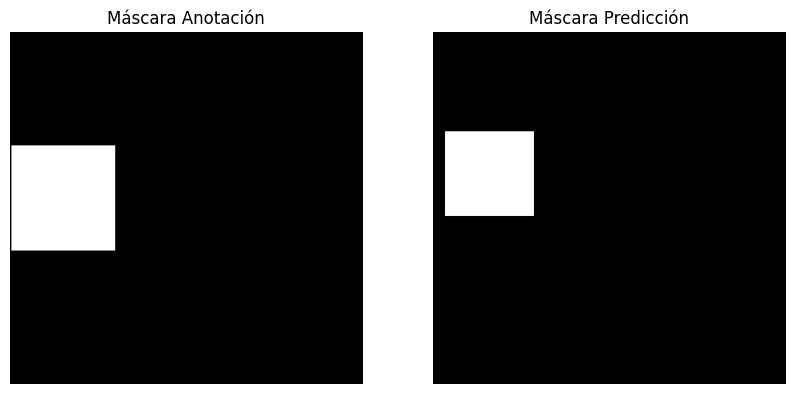

In [6]:
anotaciones = json.load(open('data_mp1/BCCD/valid/_annotations.coco.json')) # archivo .json de las predicciones
predicciones = json.load(open('data_mp1/dummy_predictions.json')) # archivo .json de las anotaciones

Ax,Ay,Aw,Ah=anotaciones["annotations"][0]["bbox"] # coordenadas de la bbox de la anotación
Px,Py,Pw,Ph=predicciones[0]["bbox"] # coordenadas de la bbox de la predicción

A = bounding_box(Ax, Ay, Aw, Ah)  # mascara binaria de la anotación
P = bounding_box(Px, Py, Pw, Ph)  # mascara binaria de la predicción

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(A, cmap="gray")
axs[0].set_title("Máscara Anotación")
axs[0].axis("off")

axs[1].imshow(P, cmap="gray")
axs[1].set_title("Máscara Predicción")
axs[1].axis("off")

plt.show()

In [7]:
assert (A.shape[0]==500), f'El tamaño de la mascara binaria debería ser 500x500 y es {A.shape}'
assert (A.shape[1]==500), f'El tamaño de la mascara binaria debería ser 500x500 y es {A.shape}'
assert (np.isclose(np.sum(A),Aw*Ah,0.1)), f'El area de la bbox de la anotación debería ser igual a la multiplicación de el ancho y el alto de la bbox'
assert (P.shape[0]==500), f'El tamaño de la mascara binaria debería ser 500x500 y es {P.shape}'
assert (P.shape[1]==500), f'El tamaño de la mascara binaria debería ser 500x500 y es {P.shape}'
assert (np.isclose(np.sum(P),Pw*Ph,0.1)), f'El area de la bbox de la predicción debería ser igual a la multiplicación de el ancho y el alto de la bbox'
assert (np.isclose(np.sum(A*P),12600,0.1))

#### 1.2 Determinación de coincidencia entre anotaciones y predicciones:

Para poder determinar que predicciones consideramos positivas o negativas, debemos determinar que tanto se "parecen" las predicciones a las anotaciones. Para lo anterior contaremos con un umbral de jaccard (j_umbral), el cual nos informará de cuan parecidas deben ser las bounding boxes de la predicción y anotación para que sean consideradas la misma. Además, ahora que tenemos una función que retorna una mascara binaria para la predicción y anotación, utilizaremos la función del indice de Jaccard **implementada en el tutorial 1** para determinar la similitud entre predicción-anotación.

Cree una función que entre como parametro una predicción y una anotación junto con un umbral de jaccard. Esta función debe retornar True o False dependiendo de si la anotación y la predicción corresponden a lo mismo.

> - Use la función bounding_box para crear las mascaras binarias.

In [8]:
def verificar_coincidencia(anotacion, prediccion, j_umbral):
    """ Esta función le entra una anotación y una predicción y determina si corresponde a lo mismo o no.

    Args:
        anotacion (dict): diccionario que contiene la información acerca de una anotación.
        prediccion (dict): diccionario que contiene la información acerca de una predicción.
        j_umbral (float): valor que corresponde al umbral de jaccard bajo el que se determinará la coincidencia.

    Returns:
        (bool): True si la anotación y predicción son lo suficientemente similares,
        (float): valor de jaccard calculado mediante la función de jaccard. Recuerde que no es lo mismo que el umbral de jaccard.
    """
    Ax, Ay, Aw, Ah = anotacion["bbox"]
    Px, Py, Pw, Ph = prediccion["bbox"]

    A = bounding_box(Ax, Ay, Aw, Ah)
    P = bounding_box(Px, Py, Pw, Ph)

    interseccion = np.logical_and(A, P).sum()
    union = np.logical_or(A, P).sum()

    jaccard_value = interseccion / union if union > 0 else 0.0
    superposicion = jaccard_value >= j_umbral # Si la predicción y la anotación corresponden a lo mismo.

    return superposicion, jaccard_value
    

In [9]:
resultado_1,_ = verificar_coincidencia(anotaciones["annotations"][3],predicciones[3],0.5)
resultado_2,_ = verificar_coincidencia(anotaciones["annotations"][1],predicciones[1],0.5)
resultado_3,_ = verificar_coincidencia(anotaciones["annotations"][0],predicciones[0],0.5)

assert not resultado_1, 'Esta anotación y predicción no deberían ser considerados como la misma'
assert not resultado_2, 'Esta anotación y predicción no deberían ser considerados como la misma'
assert resultado_3, 'Esta anotación y predicción deberían ser considerados como la misma'

#### 1.3 Metricas:

Ahora que ya tenemos una forma de verificar la coincidencia entre una predicción y una anotación lo próximo que queremos hacer es calcular las métricas para el problema de detección, es decir, dadas anotaciones y predicciones queremos calcular métricas como precisión y cobertura para medir el desempeño del modelo en este problema. 

Para eso dividiremos el calculo de las métricas en 3 funciones. La primera función evaluará los Verdaderos positivos, falsos positivos y falsos negativos para una imagen. Los parámetros de la función serán anotaciones, predicciones y un umbral de jaccard.

El parámetro de anotaciones será una lista de todas las anotaciones para una imagen en específico, lo mismo sucederá con las predicciones. En la siguiente celda tenemos un ejemplo de cómo son las anotaciones y predicciones que entrarán en la función de evaluación por imagen.

In [10]:
prediccion_ejemplo = [{'image_id': 0, 'category_id': 3, 'bbox': [17.0, 142.0, 126.0, 120.0], 'score': 0.7559071367153912}, {'image_id': 0, 'category_id': 3, 'bbox': [126.0, 179.0, 163.5, 203.0], 'score': 0.7559071367153912}]
anotacion_ejemplo = [{'id': 0, 'image_id': 0, 'category_id': 3, 'bbox': [2, 162, 147, 149], 'area': 21903, 'segmentation': [], 'iscrowd': 0}, {'id': 1, 'image_id': 0, 'category_id': 3, 'bbox': [103, 199, 158.5, 207], 'area': 21903, 'segmentation': [], 'iscrowd': 0}]

print(prediccion_ejemplo, "\n")
print(anotacion_ejemplo)

[{'image_id': 0, 'category_id': 3, 'bbox': [17.0, 142.0, 126.0, 120.0], 'score': 0.7559071367153912}, {'image_id': 0, 'category_id': 3, 'bbox': [126.0, 179.0, 163.5, 203.0], 'score': 0.7559071367153912}] 

[{'id': 0, 'image_id': 0, 'category_id': 3, 'bbox': [2, 162, 147, 149], 'area': 21903, 'segmentation': [], 'iscrowd': 0}, {'id': 1, 'image_id': 0, 'category_id': 3, 'bbox': [103, 199, 158.5, 207], 'area': 21903, 'segmentation': [], 'iscrowd': 0}]


Lo que queremos en la función es evaluar los TP, FP y FN, dentro de una imagen. Para eso realizaremos un paso intermedio el cual es emparejar cada anotación con cada predicción de la siguiente manera:

![imagen](Bipartite_graph.png)

Los pasos a seguir para construir la función es la siguiente:
1. Crear una matriz de tamaño len(anotaciones) X len(predicciones). Esta matriz contendrá en cada celda $1 - jaccard$. **Nota:** Esta matriz se llama de costos y la razón para utilizar $1 - jaccard$ es debido a que el algoritmo que utilizaremos en el paso 2 para emparejar las predicciones con las anotaciones empareja las anotaciones y predicciones con valores más pequeños.
2. Usaremos la función [linear_sum_assignment](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html) que realiza el emparejamiento entre anotaciones y predicciones. El parámetro de entrada es la matriz construida anteriormente, y retorna una lista ordenada con las filas y columnas de la matriz que fueron emparejadas.
3. Posteriormente, verificamos si los emparejamientos superan el umbral de jaccard y si lo hacen entonces estas serán verdaderos positivos.
4. Finalmente, los falsos positivos serán el número de predicciones - el número de verdaderos positivos. Así mismo los falsos negativos serán el número de anotaciones - el número de vedaderos positivos.

In [11]:
def evaluacion_por_imagen(anotaciones, predicciones, j_umbral):
    """ Esta función evalua cuantos falsos positivos, falsos negativos y verdaderos positivos hay .

    Args:
        anotaciones (list): lista de diccionarios que contiene las anotaciones. 
                            Cada diccionario contiene la información de una anotación. 
        predicciones (list): lista de diccionarios que contiene las predicciones.
                             Cada diccionario contiene la información de una predicción.
        j_umbral (float): valor que corresponde al umbral de jaccard bajo el que se determinará la coincidencia.
    
    Returns:
        (int): verdaderos positivos, (int): falsos positivos, (int): falsos negativos
    """
    
    if len(anotaciones) == 0 and len(predicciones) == 0:
        return 0, 0, 0
    if len(anotaciones) == 0:
        return 0, len(predicciones), 0
    if len(predicciones) == 0:
        return 0, 0, len(anotaciones)
    
    # 1. Crear matriz de costos (1 - jaccard)
    costos = np.zeros((len(anotaciones), len(predicciones)))
    for i, anot in enumerate(anotaciones):
        for j, pred in enumerate(predicciones):
            _, jaccard_value = verificar_coincidencia(anot, pred, j_umbral=0)  # solo valor
            costos[i, j] = 1 - jaccard_value

    # 2. Resolver el emparejamiento óptimo
    filas, cols = linear_sum_assignment(costos)

    # 3. Contar TP
    TP = 0
    for i, j in zip(filas, cols):
        _, jaccard_value = verificar_coincidencia(anotaciones[i], predicciones[j], j_umbral)
        if jaccard_value >= j_umbral:
            TP += 1

    # 4. Calcular FP y FN
    FP = len(predicciones) - TP
    FN = len(anotaciones) - TP

    return TP, FP, FN

In [12]:
anotacion_ejemplo = [anotacion for anotacion in anotaciones["annotations"] if anotacion["image_id"] == 0 and anotacion["category_id"] == 3]
prediccion_ejemplo = [prediccion for prediccion in predicciones if prediccion["image_id"] == 0 and prediccion["category_id"] == 3]

result = evaluacion_por_imagen(anotacion_ejemplo, prediccion_ejemplo, 0.5)

assert result == (1, 0, 0), f"Se esperaba (1, 0, 0) y se obtuvo {result}"

anotacion_ejemplo = [anotacion for anotacion in anotaciones["annotations"] if anotacion["image_id"] == 10 and anotacion["category_id"] == 3]
prediccion_ejemplo = [prediccion for prediccion in predicciones if prediccion["image_id"] == 10 and prediccion["category_id"] == 3]

result = evaluacion_por_imagen(anotacion_ejemplo, prediccion_ejemplo, 0.5)

assert result == (0, 1, 1), f"Se esperaba (0, 1, 1) y se obtuvo {result}"

La segunda función realizará la evaluación de los verdaderos positivos, falsos positivos y falsos negativos para todo un conjunto de datos. Esta función llamará la función anterior. Se encargará de:
1. Filtrar las anotaciones para solo obtener las que tengan category_id == 3.
2. Filtrar las predicciones, borrando las que tenga un score inferior al umbral.
3. Creando un diccionario donde la llave sea el image_id y los valores sean diccionarios que a su vez posean como llaves "anotaciones" y "predicciones". Los valores de los diccionarios internos serán listas con las anotaciones o predicciones correspondientes.
4. Finalmente, utilizaremos la función anterior para determinar la cantidad de TP, FP y FN dentro de toda la base de datos.

In [13]:
def evaluacion(anotaciones, predicciones, j_umbral, c_umbral):
    """ Esta función evalua cuantos falsos positivos, falsos negativos y verdaderos positivos.

    Args:
        anotaciones (dict): diccionario de lista de diccionarios que contiene las anotaciones. 
                            Cada diccionario contiene la información de una anotación. 
        predicciones (list): lista de diccionarios que contiene las predicciones.
                             Cada diccionario contiene la información de una anotación.
        j_umbral (float): valor que corresponde al umbral de jaccard bajo el que se determinará la coincidencia.
        c_umbral (float): valor que corresponde al umbral de confianza bajo el que se determinará si un predicción cuenta o no.
    
    Returns:
        (int): verdaderos positivos, (int): falsos positivos, (int): falsos negativos
    """
    
    # 1. Filtrar anotaciones (solo category_id == 3)
    anotaciones_filtradas = [a for a in anotaciones["annotations"] if a["category_id"] == 3]

    # 2. Filtrar predicciones por score >= c_umbral
    predicciones_filtradas = [p for p in predicciones if p["score"] >= c_umbral]

    # 3. Crear diccionario agrupado por image_id
    dataset = {}
    for anot in anotaciones_filtradas:
        img_id = anot["image_id"]
        if img_id not in dataset:
            dataset[img_id] = {"anotaciones": [], "predicciones": []}
        dataset[img_id]["anotaciones"].append(anot)

    for pred in predicciones_filtradas:
        img_id = pred["image_id"]
        if img_id not in dataset:
            dataset[img_id] = {"anotaciones": [], "predicciones": []}
        dataset[img_id]["predicciones"].append(pred)

    # 4. Evaluar imagen por imagen
    TP_total, FP_total, FN_total = 0, 0, 0
    for img_id, datos in dataset.items():
        TP, FP, FN = evaluacion_por_imagen(datos["anotaciones"], datos["predicciones"], j_umbral)
        TP_total += TP
        FP_total += FP
        FN_total += FN

    return TP_total, FP_total, FN_total

In [14]:
TP, FP, FN = evaluacion(anotaciones,predicciones,0.5,0.7)

assert TP < FN, "En este caso los verdaderos positivos son menos que los falsos negativos"
assert TP > FP, "En este caso los verdaderos positivos son más que los falsos positivos"
assert (TP + FP + FN) == 66, "En este caso la suma de los TP + FP + FN debería ser 66" 

La tercera función será la utilizada para calcular las métricas de precisión, cobertura y f-medida.

Recuerde que la formula de Precisión, Cobertura y F medida son las siguientes:

\begin{equation}
P = \frac{TP}{TP+FP+\epsilon}
\end{equation}

\begin{equation}
C = \frac{TP}{TP + FN+\epsilon}
\end{equation}

\begin{equation}
F_{medida} = \frac{2 (P \times C)}{P + C+\epsilon}
\end{equation}

El termino $\epsilon$ se agrega en la implementación del codigo como una constante pequeña (en nuestro caso dejela como $1 \times 10^{-6}$) para no afectar el calculo de las metricas pero evitar la division por 0.

In [ ]:
def Metricas(anotaciones, predicciones, j_umbral, c_umbral):
    """ Esta función utiliza la función anterior para calcular los TP, FP y FN y luego calcula las métricas

    Args:
        anotaciones (dict): lista de diccionarios que contiene las anotaciones. 
                            Cada diccionario contiene la información de una anotación. 
        predicciones (list): lista de diccionarios que contiene las predicciones.
                             Cada diccionario contiene la información de una anotación.
        j_umbral (float): valor que corresponde al umbral de jaccard bajo el que se determinará la coincidencia.
        c_umbral (float): valor que corresponde al umbral de confianza bajo el que se determinará si un predicción cuenta o no.

    Returns:
        (float): precision, (float): cobertura, (float): f-medida.
    """
    epsilon = 1e-6
    
    TP, FP, FN = evaluacion(anotaciones, predicciones, j_umbral, c_umbral)
    
    P = TP / (TP + FP + epsilon)
    C = TP / (TP + FN + epsilon)
    F = (2 * P * C) / (P + C + epsilon)
    
    return P, C, F

In [17]:
P,C,F=Metricas(anotaciones,predicciones,0.5,0.7)

assert P>0 and P<1, 'La precisión no puede ser menor a 0 ni mayor a 1'
assert C>0 and C<1, 'La cobertura no puede ser menor a 0 ni mayor a 1'
assert F>0 and F<1, 'La F medida no puede ser menor a 0 ni mayor a 1'

assert P>C, 'La precisión debe ser mayor a la cobertura para esta predicción'
assert F>C and F<P, 'La F medida debe ser mayor a la precisión y mayor a la cobertura en esta predicción'
assert (np.isclose(P*C,0.328,0.1)), 'El valor de la precisión o la cobertura es erronea'

### Parte 2: Calculo de curvas de precisión y cobertura y mAP

#### 2.1 Curva de precisión y cobertura:
Cómo podemos determinar cuál modelo es mejor? Un modelo poseerá varias caracteristicas, no es tan simple como escoger la mejor precisión o la mejor cobertura, tampoco la mejor F medida, ya que esto dependerá del umbral de confianza escogido. Variaremos entonces el valor del umbral de confianza. Cada valor para este umbral nos proporcionará una precisión y una cobertura especifica, este será un punto en el plano Precisión,Cobertura, de esta forma crearemos una curva. 

Cree una función que varie el umbral de confianza desde 0.1 hasta 1 con 100 datos y genere la precisión, cobertura y F medida con ayuda de la función Metricas. Esta función recibe como parametro el .json de anotaciones y predicciones, y un umbral de Jaccard, y deberá retornar 2 vectores (P,C) de 100 posiciones (un dato por cada umbral).
> - Recuerde variar el umbral de confianza, no el de Jaccard.

Un aspecto importante de las métricas es la F medida, queremos encontrar cual es el valor máximo de F medida alcanzado y para cual umbral de confianza. Retornen tambien estos 2 valores en la función.

Grafique la curva de precisión y cobertura. Nosotros les graficaremos unas curvas de F medida, estas curvas son la combinación de precisión y cobertura que generan una F medida especifica. De esta forma, podemos ver graficamente cual es la F medida más alta alcanzada por nuestro modelo. 


In [19]:
def Curvas_P_C(anotaciones,predicciones,jaccard):
    """ Esta función calcula la curva de precisión y cobertura utilizando las funciones anteriores.

    Args:
        anotaciones (dict): lista de diccionarios que contiene las anotaciones. 
                            Cada diccionario contiene la información de una anotación. 
        predicciones (list): lista de diccionarios que contiene las predicciones.
                             Cada diccionario contiene la información de una anotación.
        jaccard (float): valor que corresponde al umbral de jaccard bajo el que se determinará la coincidencia.

    Returns:
        (list): precision, (list): cobertura, (float): f-medida máxima, (float): umbral donde la f-medida es máxima.
    """
    umbrales = np.linspace(0.1, 1.0, 100)
    
    Pr = []
    Co = []
    f_medidas = []
    
    # Calcular métricas para cada umbral
    for c_umbral in umbrales:
        P, C, F1 = Metricas(anotaciones, predicciones, jaccard, c_umbral)
        Pr.append(P)
        Co.append(C)
        f_medidas.append(F1)
    
    # Máximo F-medida
    F = max(f_medidas)
    umbral = umbrales[f_medidas.index(F)]
    
    # Graficar curva P-C
    plt.figure(figsize=(7,5))
    plt.plot(Co, Pr, marker='o', markersize=3, label="Curva Precisión-Cobertura")
    plt.xlabel("Cobertura (Recall)")
    plt.ylabel("Precisión")
    plt.title("Curva Precisión vs Cobertura")
    plt.legend()
    plt.grid(True)
    plt.show()

    return Pr,Co,F,umbral

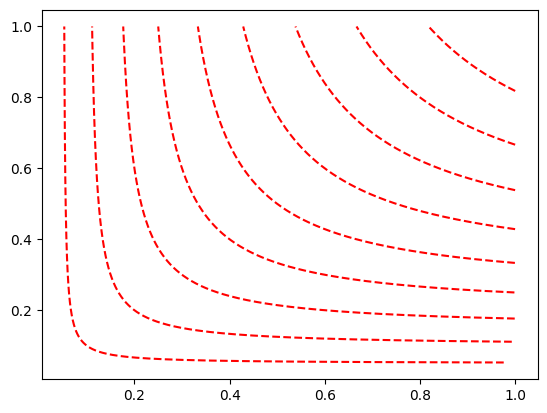

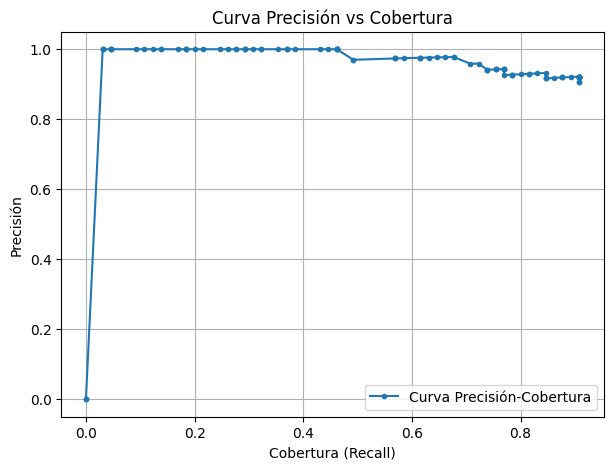

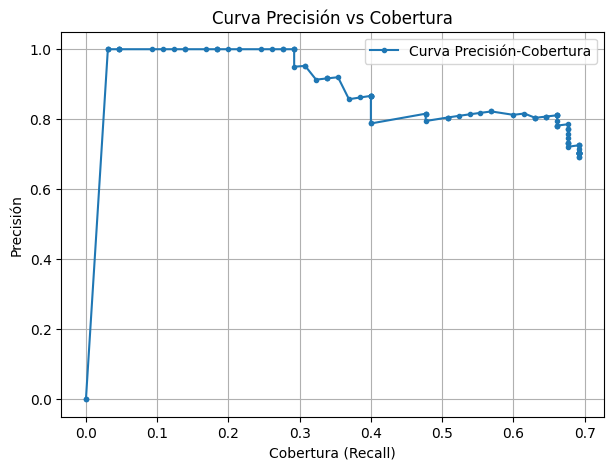

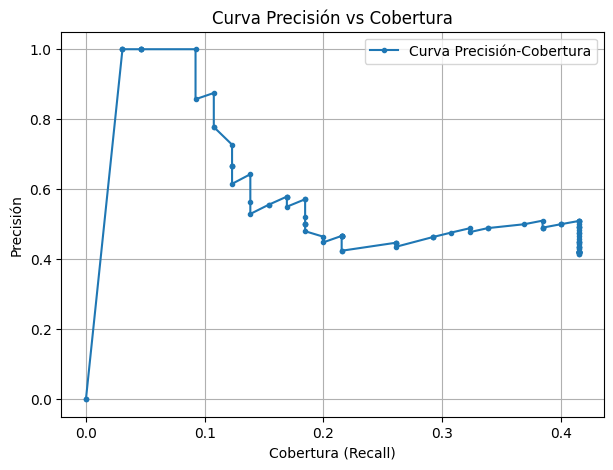

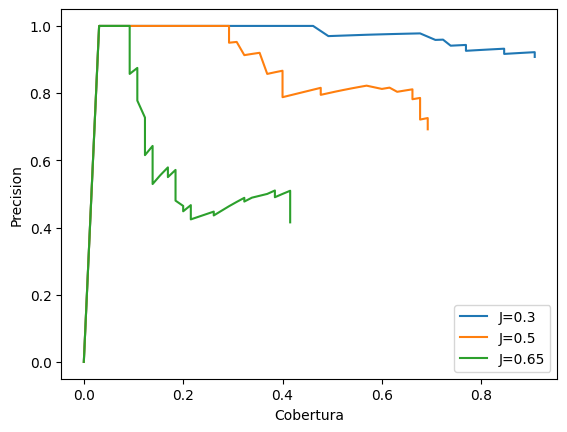

In [20]:
import numpy as np
from matplotlib import pyplot as plt
    
#Dibujamos las curvas de F medida
p=np.arange(0.0001,1.0001,0.0001)
for f in np.arange(0.0,1.2,0.1): #saltos de 0.1 desde una F medida de 0 hasta una F medida de 1
    aux=np.zeros(len(p))
    for i in range(len(p)):
        k=(2*p[i]-f)
        if k>0.001:
            c=f*p[i]/k
            aux[i]=c
    c=np.copy(aux)
    c=c*(c<=1)
    l2=np.where(c!=0)[0]
    C=c[l2]
    P=p[l2]
    plt.plot(C,P,'r--')
Pr1,Co1,F1,umbral1=Curvas_P_C(anotaciones,predicciones,0.4)
Pr2,Co2,F2,umbral2=Curvas_P_C(anotaciones,predicciones,0.55)
Pr3,Co3,F3,umbral3=Curvas_P_C(anotaciones,predicciones,0.65)
plt.plot(Co1,Pr1,label='J=0.3')
plt.plot(Co2,Pr2,label='J=0.5')
plt.plot(Co3,Pr3,label='J=0.65')
plt.xlabel('Cobertura')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [21]:
assert (len(Pr1)==100)
assert (len(Co1)==100)
assert (len(Pr2)==100)
assert (len(Co2)==100)
assert (len(Pr3)==100)
assert (len(Co3)==100)
assert (1 in np.isclose(np.around(Pr1,4),np.ones(100)*0.9077,0.01))
assert (1 in np.isclose(np.around(Pr2,4),np.ones(100)*0.6923,0.01))

#### 2.2 Calcular mAP

Una metrica importante del desempeño del modelo es el mAP, que es, en esencia, el area bajo la curva de la curva de precisión y cobertura. Obtenga el area bajo la curva del modelo. El calculo de esta metrica se encuentra acontinuación.

In [22]:
def mAP(precision,cobertura):
    """ Esta función calcula el mAP para una curva de precisión y cobertura

    Args:
        precision (numpy.ndarray): Arreglo que contiene los valores de precisión para diferentes umbrales.
        cobertura (numpy.ndarray): Arreglo que contiene los valores de cobertura para diferentes umbrales.

    Returns:
        (float): Valor de mAP.
    """
    A=0
    for i in range(len(cobertura)-1):
        A+=(cobertura[i]-cobertura[i+1])*precision[i]
    return A


Encuentre el umbral de Jaccard al que se halló la mayor f-medida posible. Use la siguiente celda para graficar la curva de precisión y cobertura e imprimir el mAP. Haga al menos 5 experimentos.

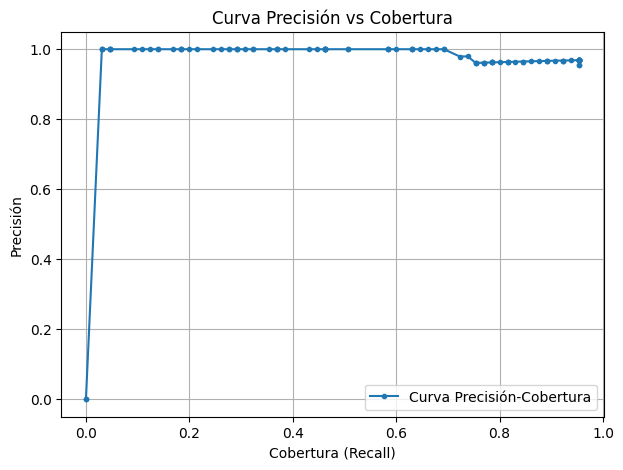

--- Jaccard = 0.3 ---
F-medida máxima: 0.9612 con umbral 0.12
mAP = 0.9454


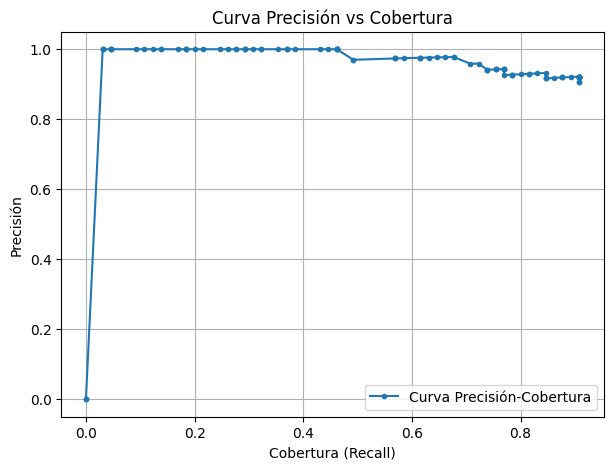

--- Jaccard = 0.4 ---
F-medida máxima: 0.9147 con umbral 0.12
mAP = 0.8873


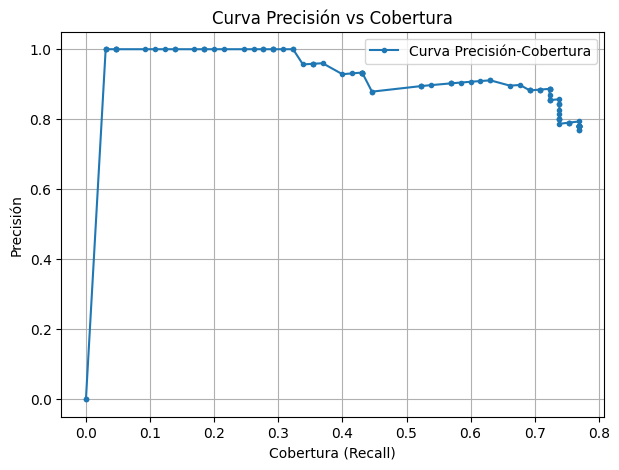

--- Jaccard = 0.5 ---
F-medida máxima: 0.7966 con umbral 0.38
mAP = 0.7241


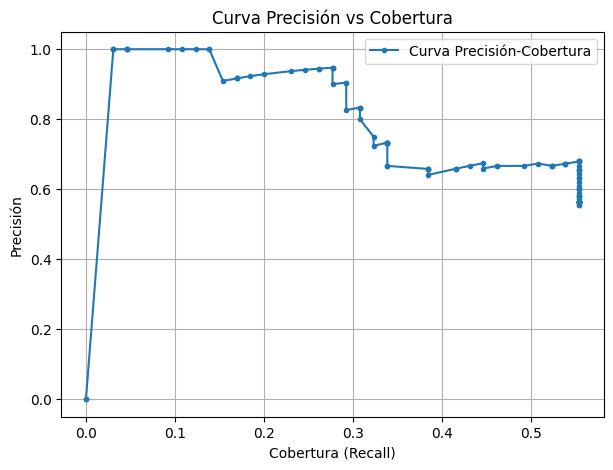

--- Jaccard = 0.6 ---
F-medida máxima: 0.6102 con umbral 0.38
mAP = 0.4605


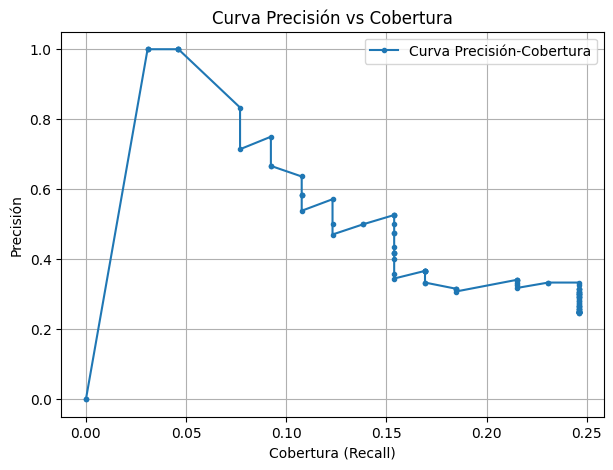

--- Jaccard = 0.7 ---
F-medida máxima: 0.2832 con umbral 0.48
mAP = 0.1490


In [23]:
# Experimento 1: 0.3
Pr1, Co1, F1, umbral1 = Curvas_P_C(anotaciones, predicciones, jaccard=0.3)
area1 = mAP(np.array(Pr1), np.array(Co1))
print(f"--- Jaccard = 0.3 ---")
print(f"F-medida máxima: {F1:.4f} con umbral {umbral1:.2f}")
print(f"mAP = {area1:.4f}")

# Experimento 2: 0.4
Pr2, Co2, F2, umbral2 = Curvas_P_C(anotaciones, predicciones, jaccard=0.4)
area2 = mAP(np.array(Pr2), np.array(Co2))
print(f"--- Jaccard = 0.4 ---")
print(f"F-medida máxima: {F2:.4f} con umbral {umbral2:.2f}")
print(f"mAP = {area2:.4f}")

# Experimento 3: 0.5
Pr3, Co3, F3, umbral3 = Curvas_P_C(anotaciones, predicciones, jaccard=0.5)
area3 = mAP(np.array(Pr3), np.array(Co3))
print(f"--- Jaccard = 0.5 ---")
print(f"F-medida máxima: {F3:.4f} con umbral {umbral3:.2f}")
print(f"mAP = {area3:.4f}")

# Experimento 4: 0.6
Pr4, Co4, F4, umbral4 = Curvas_P_C(anotaciones, predicciones, jaccard=0.6)
area4 = mAP(np.array(Pr4), np.array(Co4))
print(f"--- Jaccard = 0.6 ---")
print(f"F-medida máxima: {F4:.4f} con umbral {umbral4:.2f}")
print(f"mAP = {area4:.4f}")

# Experimento 5: 0.7
Pr5, Co5, F5, umbral5 = Curvas_P_C(anotaciones, predicciones, jaccard=0.7)
area5 = mAP(np.array(Pr5), np.array(Co5))
print(f"--- Jaccard = 0.7 ---")
print(f"F-medida máxima: {F5:.4f} con umbral {umbral5:.2f}")
print(f"mAP = {area5:.4f}")


### Parte 3: Segmentación a detección
La metodología que usaremos para detectar un glóbulo blanco será a partir de una máscara de segmentación, la idea será crear un recuadro alrededor de la segmentación del glóbulo. Existen varias metodologías para resolver este problema, nosotros utilizaremos una que constará de utilizar el componente conexo más grande.

#### 3.1 Segmentación

Como en la entrega pasada ya utilizamos la segmentación mediante un umbral arbitrario, es decir, un umbral que elegimos al azar, Ahora, trataremos de umbralizar con un umbral elegido estadísticamente lo cual es llamado umbralizado por percentiles. Este tipo de umbralización tiene la ventaja de que mantiene siempre la cantidad de pixeles considerados dentro de la segmentación. Cabe aclarar, el percentil es únicamente el medio por el cual obtenemos el umbral, es decir, es la forma en la que obtendremos cual es nuestro punto de corte para valer las intensidades. Cree una función que entre como parámetro una imagen y el percentile a usar, y usted retorne una imagen umbralizada.

Puede usar np.percentile para obtener el umbral. En el siguiente [enlace](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) está la documentación de la función.

**Nota:** Recuerde que la imagen que entre como parámetro debe estar en escala de grises. Por lo tanto, si ingresa una imagen a color se debe retornar error. Ese error ya ha sido agregado en la función, esta nota es para que lo tengan en cuenta y no eliminen esa línea.

In [ ]:
def umbralizacion_percentile(im, percentile):
    """ Esta función umbraliza una imagen de acuerdo al percentil dado.

    Args:
        im (numpy.ndarray): Imagen a umbralizar.
        percentile (float): Percentile que se usará para umbralizar la imagen. Por ejemplo, 4 correspondiente a 4% 

    Returns:
        (numpy.ndarray): Imagen umbralizada
    """
    
    assert len(im.shape) < 3, "La imagen debe ser en escala de grises"

    umbral = np.percentile(im, percentile)
    percentilebin_img = (im < umbral)#imagen umbralizada
    
    return percentilebin_img


8543 8578 0.01


(np.float64(-0.5), np.float64(415.5), np.float64(415.5), np.float64(-0.5))

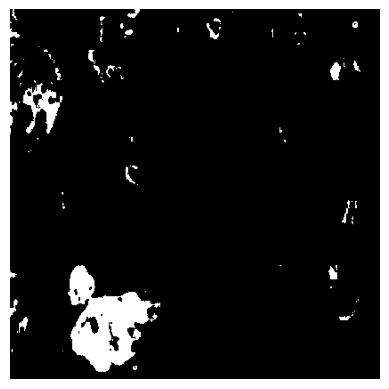

In [35]:
list_train = glob(os.path.join("data_mp1", "BCCD", "train", "*.jpg"))
list_train.sort()
img = imread(list_train[0])

new_img = umbralizacion_percentile(img[:,:,0], 5).astype(np.uint8)
assert len(new_img.shape) < 3, "La imagen debe ser en escala de grises"
assert np.isclose(np.sum(new_img), 8578, 0.01), "No realizó la umbralización de la forma correcta"

plt.imshow(new_img, cmap = "gray")
plt.axis("off")

#### 3.2 Detección mediante componente conexo más grande

Ahora que ya tenemos una segmentación a priori, lo siguiente es realizar la detección. Para eso, utilizaremos una metodología llamada componente conexo más grande.

Entonces, el procedimiento lo realizaremos con una función llamada [connectedComponentsWithStats](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gae57b028a2b2ca327227c2399a9d53241). Esta función retorna cada uno de los componentes conexos y además nos retorna información muy importante cómo puede ser el área de ese componente conexo así cómo su valores de x, y, w y h, que corresponden al punto superior izquierdo de la caja delimitadora así cómo su ancho y alto.

Esta función retorna 4 objetos. La que nos interesa es el tercer objeto, el cual contiene las estadísticas de cada componente conexo. Este tercer objeto es un arreglo de arreglos, estos últimos tienen 5 posiciones donde la primera es la coordenada x de la esquina superior izquierda, la segunda es la coordenada y de la esquina superior izquierda, la tercera es el ancho de la caja delimitadora, la cuarta es el alto de la caja de limitadora. Finalmente, la última coordenada es el área de ese componente conexo particular.

La idea es que con ayuda de esa función encuentren el elemento conexo más grande sin contar el fondo.

In [36]:
def mask2bbox(img_bin):
    """ Esta función devuelve la caja de limitadora en el formato (x, y, w, h).

    Args:
        img_bin (numpy.ndarray): Imagen segmentada.

    Returns:
        (tuple): Caja delimitadora formato (x, y, w, h).
    """
    img_bin = img_bin.astype(np.uint8)
    numero, labels, estad, centroides = cv2.connectedComponentsWithStats(img_bin)
    grande = 1 + np.argmax(estad[1:, cv2.CC_STAT_AREA])

    x = int(estad[grande, cv2.CC_STAT_LEFT]) # Coordenada x de la esquina superior izquierda
    y = int(estad[grande, cv2.CC_STAT_TOP]) # Coordenada y de la esquina superior izquierda
    w = int(estad[grande, cv2.CC_STAT_WIDTH]) # Ancho de la caja
    h = int(estad[grande, cv2.CC_STAT_HEIGHT]) # Altura de la caja

    return x, y, w, h

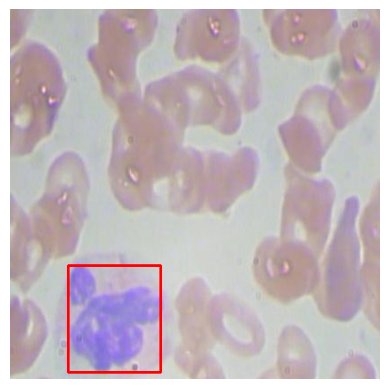

In [37]:
min_x, min_y, w, h = mask2bbox(new_img)

max_x = min_x + w
max_y = min_y + h
assert np.isclose(np.sum(img[min_y:max_y, min_x: max_x]), 6543623, 0.01) or np.isclose(np.sum(img[min_y:max_y, min_x: max_x]), 6757434, 0.01), "Los valores para la caja no son correctos"
assert min_y < max_y, "La coordenada en y de la esquina superior izquierda debería ser mayor a la coordenada en la esquina inferior derecha"
assert min_x < max_x, "La coordenada en x de la esquina superior izquierda debería ser mayor a la coordenada en la esquina inferior derecha"

img_bbox=cv2.rectangle(img, (min_x, min_y), (max_x, max_y), (255,0,0),2)

assert np.isclose(np.sum(img_bbox), 94149339, 0.01), "Los valores para la caja no son correctos"

plt.imshow(img_bbox, cmap='gray')
_ = plt.axis('off')

## Entregables
Los entregables para esta primera entrega son los siguientes:

- Jupyter notebook (.ipynb): El notebook debe estar completamente resuelto. Recuerden que la nota depende del correcto funcionamiento de su código.

- Archivo de texto (.txt): Un archivo de texto con las secciones de código del Jupyter notebook.

- Informe (.pdf): El informe constará de responder las preguntas, además, asegúrese de incluir los elementos adicionales, como subplots, gráficos, tablas o cualquiera elemento adicional que se mencione. Toda la información sobre preguntas y elementos adicionales está en la siguiente sección de informe. El informe debe utilizar el formato que puede encontrar siguiente [enlace](https://github.com/cvpr-org/author-kit). Si tiene dudas de cómo utilizar el formato puede preguntar al Asistente Graduado.

## Informe

La extensión máxima es de 4 páginas. Las preguntas a responder en su informe son las siguientes.

### Parte 1: Calculo de precisión y cobertura

Un problema de detección es, en esencia, un problema de clasificación por ventanas, por lo que podemos utilizar las mismas métricas de clasificación, pero con ligeras modificaciones. En ese sentido conteste las siguientes preguntas:

- Explique cómo se realiza la evaluación de las predicciones. Para esto tenga en cuenta las funciones verificar_coincidencia, evaluacion_por_imagen, evaluacion y métricas. Puede realizar un pseudo código si lo considera necesario. Debe ser claro y su implementación debe ser consistente con la explicación que de en el informe, de lo contrario se hará una penalización en el código y el informe.
- Si quisieramos encontrar únicamente glóbulos blancos dentro de las imágenes ¿Sería más conveniente mayor precisión o cobertura? Justifique su respuesta.

### Parte 2: Calculo de curvas de precisión y cobertura y mAP

La curva de precisión y cobertura es una metodología de evaluación que nos permite determinar la eficiencia de nuestro modelo de detección. Es importante conocer las características de nuestro modelo y para que determinados momentos funciona mejor o peor. Teniendo eso en cuenta conteste las siguientes preguntas: 

- ¿A que parámetro es sensible la curva de precisión y cobertura? Justifique su respuesta. **Consejo:** Recuerde cual es la definición de un parámetro.
- Presente los resultados de todos sus experimentos y analícelos ¿En cuál umbral de jaccard se obtuvo una mayor F medida?
- Explique cuales son las ventajas y desventajas para un umbral de jaccard alto y para un umbral de jaccard bajo.
- Investigue cómo se evaluaría un modelo de detección, si en vez de una sola categoría ahora nos tocara detectar varias categorías.

### Parte 3: Segmentación a detección

Una forma efectiva para realizar una detección es, primero, realizar una segmentación para luego agregar una caja alrededor de la máscara. Esta metodología tiene sentido, pero tambien tiene algunos problemas asociados. Responda las siguientes preguntas:

- Explique ¿qué es la umbralización mediante percentile? Además, compárelo respecto a umbralización con un umbral arbitrario (la que realizamos en la entrega 1). 
- Mencione las ventajas y desventajas de la metodología que implementamos.
- ¿Que debemos cambiar si deseamos detectar más de un glóbulo blanco en una única imagen?

In [38]:
from utils import *
converter('Entrega 2')